<a href="https://colab.research.google.com/github/yantrikeer/HandGloveCode_TMP/blob/main/WebApp_Power_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Peak power demand Forcasting Models**

##Mount drive

In [2]:
#Import Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install prophet

##Import common libraries

In [4]:
import datetime
from calendar import month_abbr  # for an ordered list of months
import math
import itertools

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

from prophet import Prophet
from xgboost import XGBRegressor


##Import data

In [8]:
df_raw=pd.read_csv('/content/drive/MyDrive/Final Year Project (Power Consumption)/States PowerData/WestBengal_PowerData-Bengal_PowerData.csv')



View Data

In [9]:
df_raw.head(20)

,Date,PeakDemand_MW,EnergyRequired_MU
0,06-01-2011,"6,089","3,286"
1,07-01-2011,"6,301","3,543"
2,08-01-2011,"6,382","3,503"
3,09-01-2011,6478,"3,397"
4,10-01-2011,"6,555","3,398"
5,11-01-2011,"5,947","2,779"
6,12-01-2011,"5,970","2,819"
7,01-01-2012,"5,610","2,930"
8,02-01-2012,"6,186","2,901"
9,03-01-2012,"6,592","3,634"


#Data Preprocessing

###Information of the data

In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date               146 non-null    object
 1   PeakDemand_MW      146 non-null    object
 2   EnergyRequired_MU  146 non-null    object
dtypes: object(3)
memory usage: 3.5+ KB


###Describe Data

In [11]:
df_raw.describe()

,Date,PeakDemand_MW,EnergyRequired_MU
count,146,146,146
unique,146,143,146
top,06-01-2011,"6,089","3,286"
freq,1,2,1


### Check Null values in the dataset

In [12]:
df_raw.isnull().sum()

Date                 0
PeakDemand_MW        0
EnergyRequired_MU    0
dtype: int64

###Make a dataframe with relevant columns only

In [13]:
# select relevant columns only columns
df_PD=df_raw[['Date', 'PeakDemand_MW']]
df_ER=df_raw[['Date', 'EnergyRequired_MU']]

In [14]:
df_PD["PeakDemand_MW"] = df_PD["PeakDemand_MW"].str.replace(',', '').astype(float)

<ipython-input-14-ad5fb7e5033f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PD["PeakDemand_MW"] = df_PD["PeakDemand_MW"].str.replace(',', '').astype(float)


In [15]:
df_PD.head(10)

,Date,PeakDemand_MW
0,06-01-2011,6089.0
1,07-01-2011,6301.0
2,08-01-2011,6382.0
3,09-01-2011,6478.0
4,10-01-2011,6555.0
5,11-01-2011,5947.0
6,12-01-2011,5970.0
7,01-01-2012,5610.0
8,02-01-2012,6186.0
9,03-01-2012,6592.0


In [16]:
df_PD["Date"] = pd.to_datetime(df_PD["Date"])
df_PD.dtypes


<ipython-input-16-7919b4149854>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PD["Date"] = pd.to_datetime(df_PD["Date"])


Date             datetime64[ns]
PeakDemand_MW           float64
dtype: object

###Extracting Month & Year

In [17]:
dataset=df_PD
dataset['Month']=pd.to_datetime(df_PD["Date"]).dt.month
dataset['Year']=pd.to_datetime(df_PD["Date"]).dt.year
dataset.head(3)


,Date,PeakDemand_MW,Month,Year
0,2011-06-01,6089.0,6,2011
1,2011-07-01,6301.0,7,2011
2,2011-08-01,6382.0,8,2011


Drop Month & Year columns

In [18]:
dataset=dataset.drop(['Month', 'Year'], axis=1)

###Data

In [19]:
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset["PeakDemand_MW"] = dataset["PeakDemand_MW"].astype(float)
dataset.dtypes

Date             datetime64[ns]
PeakDemand_MW           float64
dtype: object

###Visualize Data

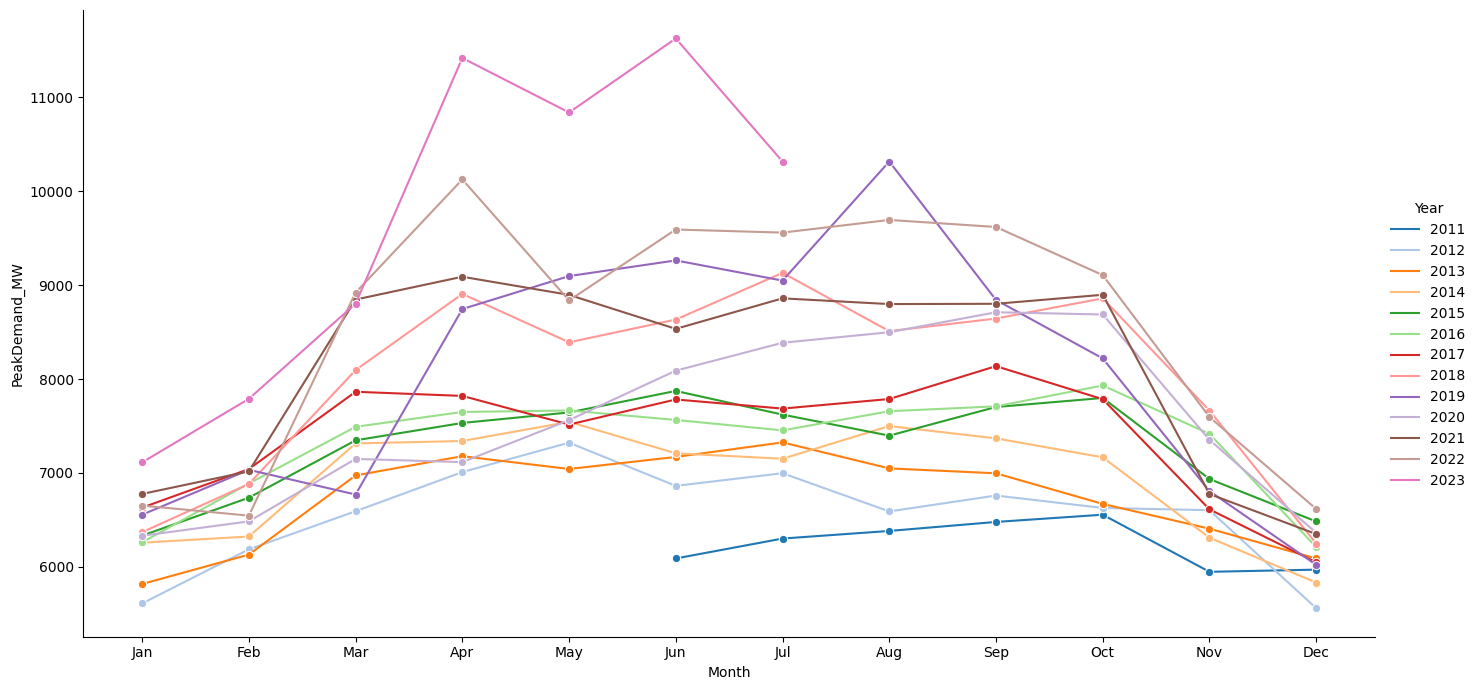

In [20]:

#NormalkWh_monthly["Date"] = pd.to_datetime(NormalkWh_monthly["Date"])

# #extract year
dataset['Year'] = dataset.Date.dt.year

# # extract abbreviated month names
dataset['Month'] = dataset.Date.dt.strftime('%b')

# # set the Month column to ordered categorical values so the x-axis will be ordered correctly
dataset.Month = pd.Categorical(dataset.Month, month_abbr[1:])

# plot
g = sns.relplot(kind='line', data=dataset, x='Month', y='PeakDemand_MW', hue='Year', palette='tab20', marker='o', height=7, aspect=2, errorbar=None)

In [21]:
peak_demand= dataset.set_index("Date")
peak_demand.head()


,PeakDemand_MW,Year,Month
Date,,,
2011-06-01,6089.0,2011,Jun
2011-07-01,6301.0,2011,Jul
2011-08-01,6382.0,2011,Aug
2011-09-01,6478.0,2011,Sep
2011-10-01,6555.0,2011,Oct


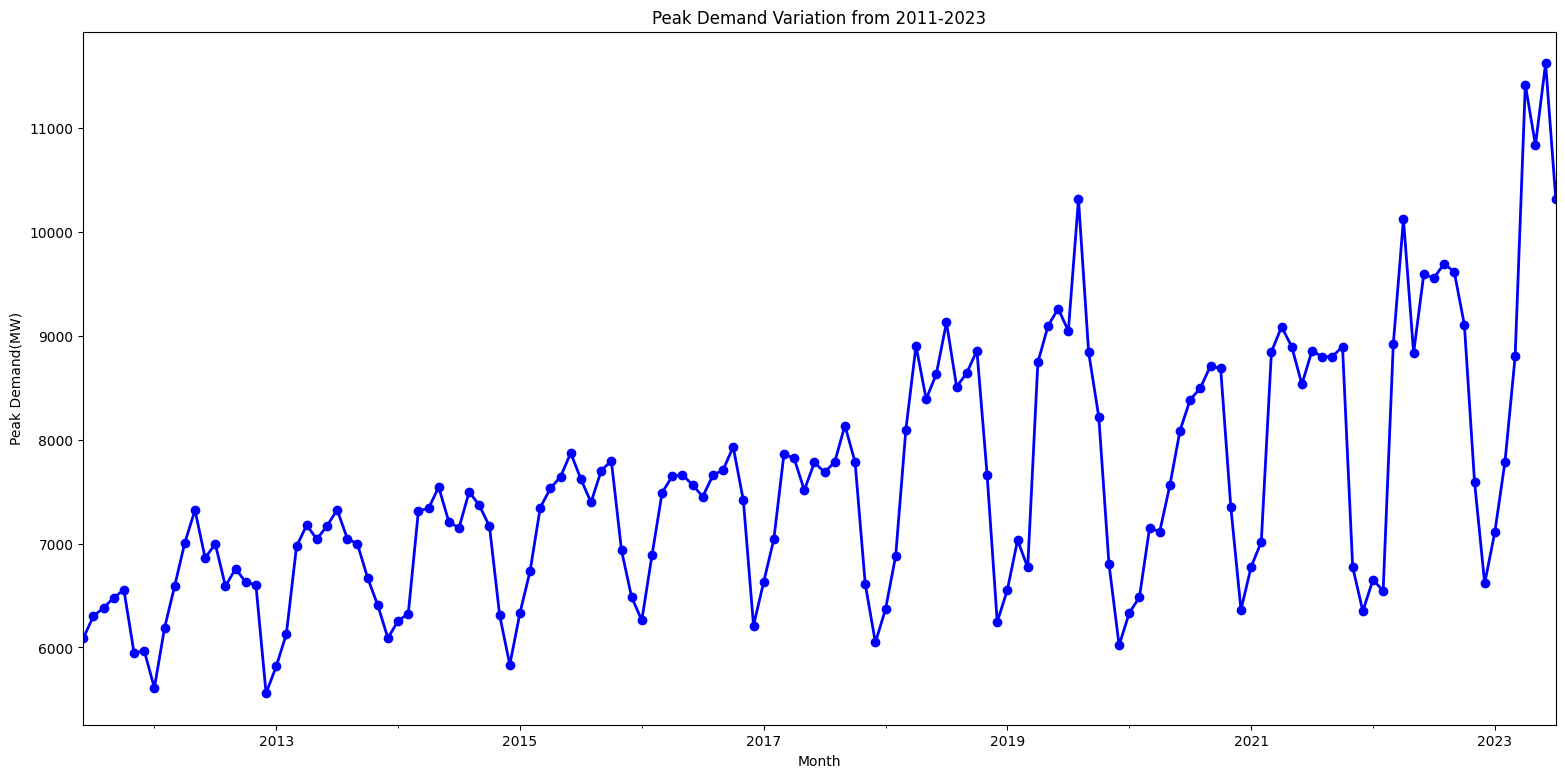

In [22]:
plt.figure(figsize=(19,9))
ax= peak_demand.loc["2011":"2023", "PeakDemand_MW"].plot(linewidth=2,color='b',marker='o')
ax.set_ylabel("Peak Demand(MW)")
ax.set_title("Peak Demand Variation from 2011-2023");
ax.set_xlabel("Month");

In [23]:
peak_demand.head()

,PeakDemand_MW,Year,Month
Date,,,
2011-06-01,6089.0,2011,Jun
2011-07-01,6301.0,2011,Jul
2011-08-01,6382.0,2011,Aug
2011-09-01,6478.0,2011,Sep
2011-10-01,6555.0,2011,Oct


In [24]:
df_data=peak_demand.drop(['Month', 'Year'], axis=1)
df_data

,PeakDemand_MW
Date,
2011-06-01,6089.00
2011-07-01,6301.00
2011-08-01,6382.00
2011-09-01,6478.00
2011-10-01,6555.00
...,...
2023-03-01,8802.74
2023-04-01,11418.40
2023-05-01,10838.17


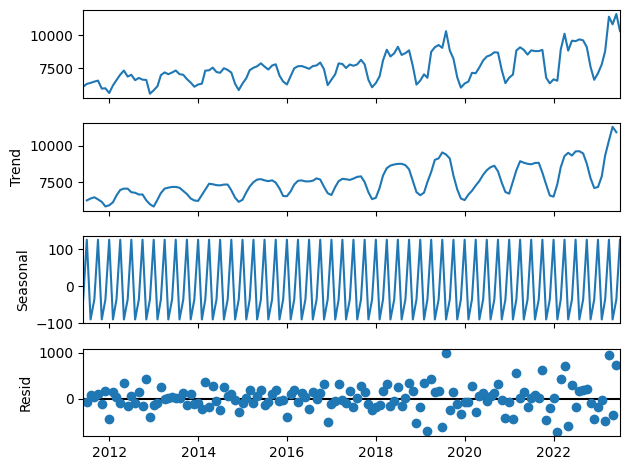

In [25]:
seasonal_decompose(df_data, period=3).plot()
plt.show()

##Moving Average

In [26]:
ma = df_data.resample('M').mean()
ma
# 3 Months Example
ma['Moving Average'] = ma['PeakDemand_MW'].rolling(3).mean()
ma.head()

,PeakDemand_MW,Moving Average
Date,,
2011-06-30,6089.0,NaN
2011-07-31,6301.0,NaN
2011-08-31,6382.0,6257.333333
2011-09-30,6478.0,6387.000000
2011-10-31,6555.0,6471.666667


In [27]:
def moving_average(data, window):
    data['Moving Average'] = data['PeakDemand_MW'].rolling(window).mean()
    actual = data['PeakDemand_MW'][-(window+140):]
    ma = data['Moving Average'][-(window+140):]

    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    ma.plot(label='MA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('{}-Months Moving Average'.format(str(window)), weight='bold', fontsize=25)
    plt.legend()

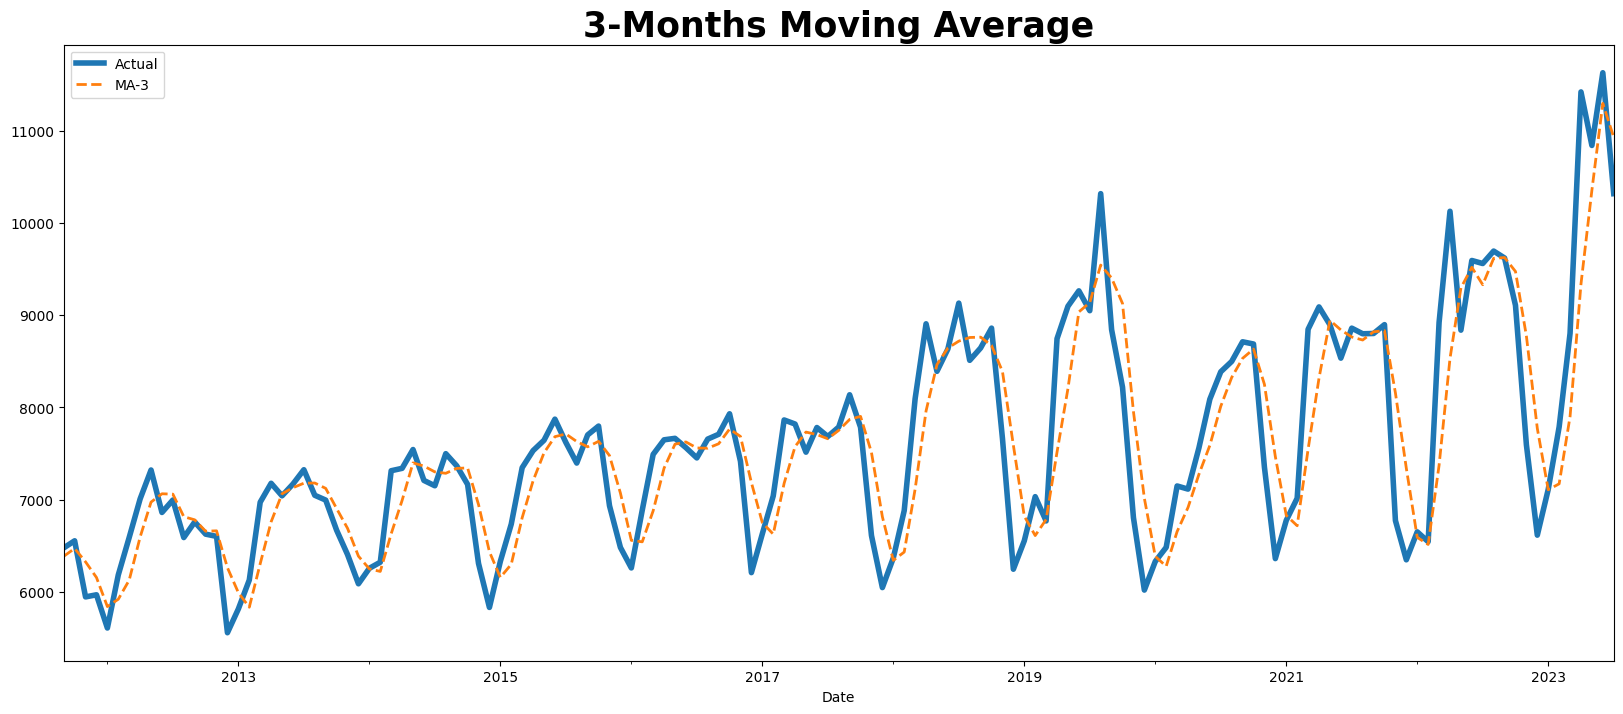

In [28]:
moving_average(ma, 3)

##Data Splitting into Training and Testing Set

In [29]:
# Before building and training our model, let's split the data into training and testing
df_train, df_test = df_data[df_data.index < '2020-01-01'], df_data[df_data.index >= '2020-01-01']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 103
Test:	 43


In [30]:
df_train

,PeakDemand_MW
Date,
2011-06-01,6089.0
2011-07-01,6301.0
2011-08-01,6382.0
2011-09-01,6478.0
2011-10-01,6555.0
...,...
2019-08-01,10316.0
2019-09-01,8842.0
2019-10-01,8219.0


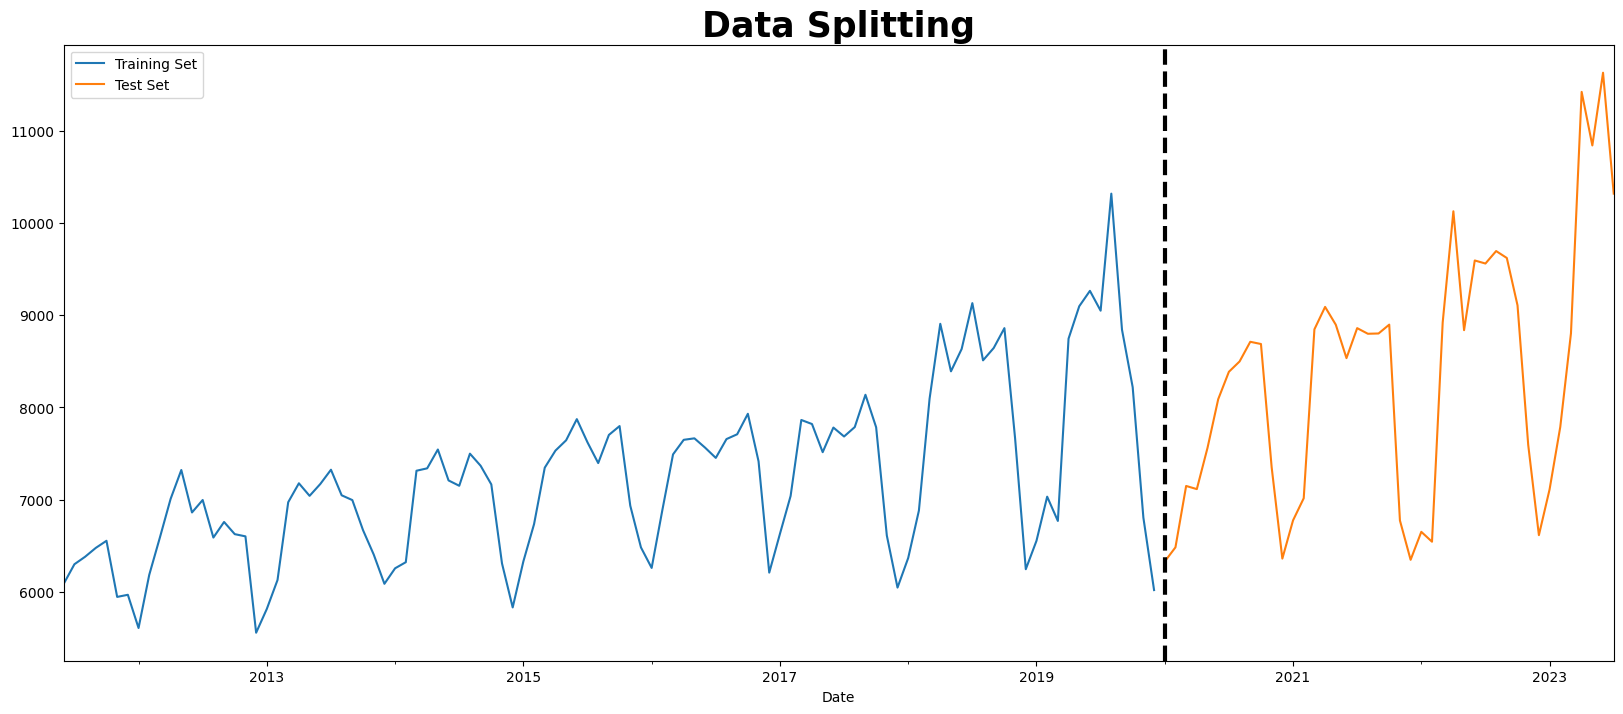

In [31]:
plt.figure(figsize=(20,8))

df_train['PeakDemand_MW'].plot(label='Training Set')
df_test['PeakDemand_MW'].plot(label='Test Set')
plt.axvline('2020-01-01', color='black', ls='--', lw=3)
#plt.text('2023-02-01', 10, 'Split', fontsize=20, fontweight='bold')
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend()

#Models

<a id="5"></a>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>1. Prophet</b></h1>

Prophet is an open-source library for univariate (one variable) time series forecasting developed by Facebook. It works best with time series that have strong seasonal effects and several seasons of historical data

Official Documentation: [Here](http://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,several%20seasons%20of%20historical%20data.)

Helpful Resources:
* https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
* https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet/notebook

In [32]:
def index_to_column(data):
    data = data.reset_index()
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values('Date')

    data = data.rename(columns={'Date': 'ds', 'PeakDemand_MW': 'y'})
    return data

In [33]:
prophet_train = index_to_column(df_train)
prophet_test = index_to_column(df_test)

In [34]:
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']]) # Keep the dataset format

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0skpa_vp/zkyjfer2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0skpa_vp/wph2z5qz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35910', 'data', 'file=/tmp/tmp0skpa_vp/zkyjfer2.json', 'init=/tmp/tmp0skpa_vp/wph2z5qz.json', 'output', 'file=/tmp/tmp0skpa_vp/prophet_modelwvsbo_kg/prophet_model-20240101083128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


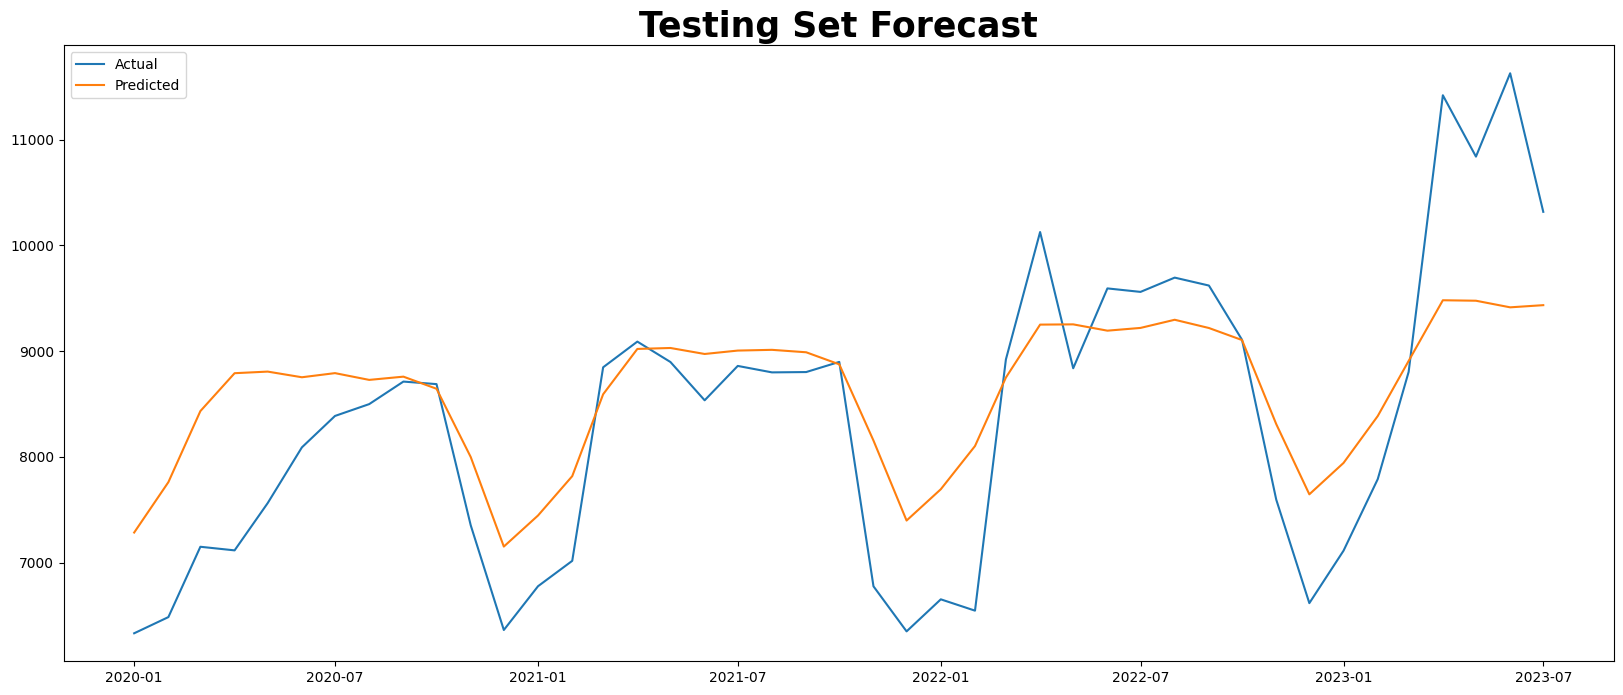

In [35]:
mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)

plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
plt.title('Test Forecasting', weight='bold', fontsize=40)
#plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()

In [36]:
print(mae)

694.929


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Predict the value for next 7 months</b></h1>

In [37]:
# This time, we will use all data (train and test) to train our model
new_df = index_to_column(df_data)

In [38]:

prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_df)
# 7 months to the future
future_months = prophet_model2.make_future_dataframe(periods=12, freq='M')
prophet_pred2 = prophet_model2.predict(future_months)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0skpa_vp/9oc25_r4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0skpa_vp/bd8o3ske.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70047', 'data', 'file=/tmp/tmp0skpa_vp/9oc25_r4.json', 'init=/tmp/tmp0skpa_vp/bd8o3ske.json', 'output', 'file=/tmp/tmp0skpa_vp/prophet_modell68gvhg0/prophet_model-20240101083140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 2000x800 with 0 Axes>

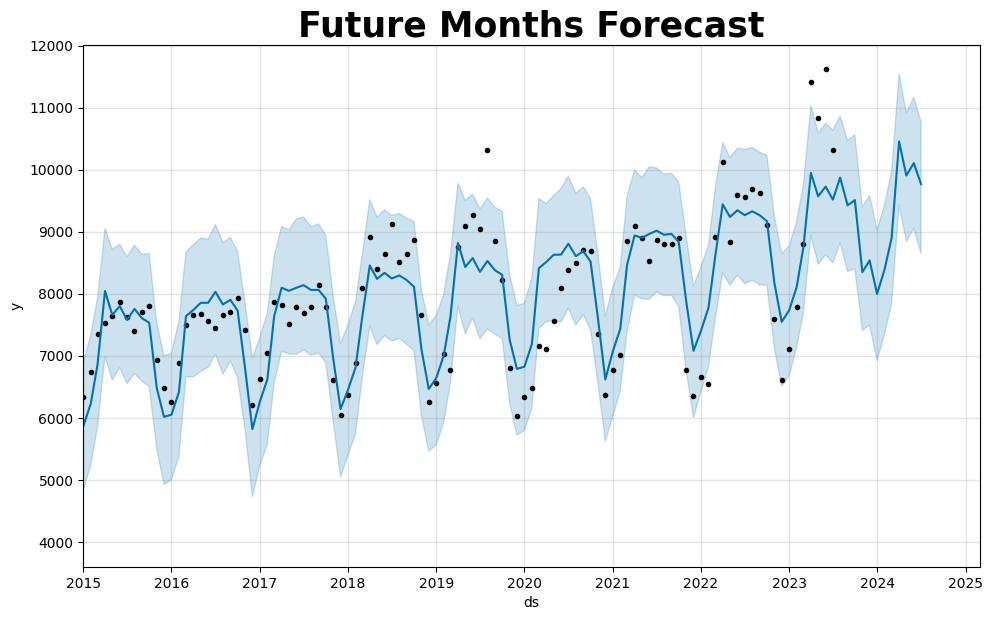

In [39]:
plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2015-01-01', '2025-03-1']))
plt.title('Future Months Forecast', weight='bold', fontsize=25)
plt.show()

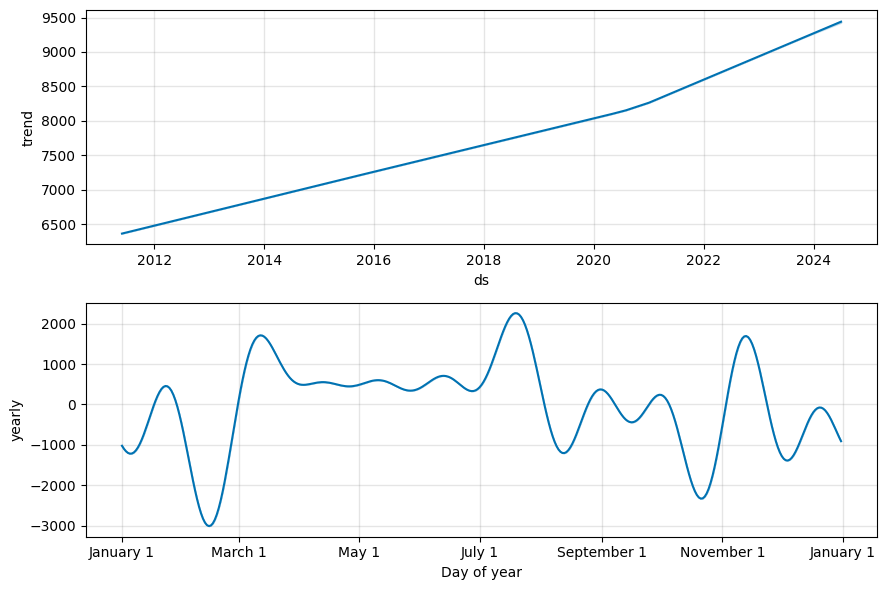

In [40]:
prophet_model.plot_components(prophet_pred2)
plt.show()

##<a id="6"></a>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>2. XGBoost</b></h1>

XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm

The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems

To be able to use XGBoost for time series forecasting, the data should be transformed into supervised learning before feeding it into the model

Official Documentation: [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

Helpful Resources:
* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
* https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost

In [41]:
def date_transform(data):
    df_10 = data.copy()

    #df['Hour'] = df.index.hour
    #df['Dayofweek'] = df.index.dayofweek
    #df['Dayofmonth'] = df.index.day
    #df['Dayofyear'] = df.index.dayofyear
    #df['weekofyear'] = df.index.weekofyear
    df_10['Month'] = df_10.index.month
    df_10['Quarter'] = df_10.index.quarter
    df_10['Year'] = df_10.index.year

    X = df_10.drop('PeakDemand_MW', axis=1)
    y = df_10['PeakDemand_MW']

    return X, y

In [42]:
df_train

,PeakDemand_MW
Date,
2011-06-01,6089.0
2011-07-01,6301.0
2011-08-01,6382.0
2011-09-01,6478.0
2011-10-01,6555.0
...,...
2019-08-01,10316.0
2019-09-01,8842.0
2019-10-01,8219.0


In [43]:
X_train, y_train = date_transform(df_train)
X_test, y_test = date_transform(df_test)
X_train


,Month,Quarter,Year
Date,,,
2011-06-01,6,2,2011
2011-07-01,7,3,2011
2011-08-01,8,3,2011
2011-09-01,9,3,2011
2011-10-01,10,4,2011
...,...,...,...
2019-08-01,8,3,2019
2019-09-01,9,3,2019
2019-10-01,10,4,2019


In [44]:
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, early_stopping_rounds=8)
xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_pred = xgb_model.predict(X_test)

[0]	validation_0-mae:694.12832	validation_1-mae:1389.96982
[1]	validation_0-mae:664.49241	validation_1-mae:1344.39165
[2]	validation_0-mae:636.19968	validation_1-mae:1300.92492
[3]	validation_0-mae:609.13188	validation_1-mae:1260.21285
[4]	validation_0-mae:582.81543	validation_1-mae:1222.66812
[5]	validation_0-mae:558.31299	validation_1-mae:1189.07797
[6]	validation_0-mae:535.06273	validation_1-mae:1157.47326
[7]	validation_0-mae:512.98612	validation_1-mae:1127.37063
[8]	validation_0-mae:491.67725	validation_1-mae:1098.97451
[9]	validation_0-mae:471.52923	validation_1-mae:1071.90783
[10]	validation_0-mae:452.20290	validation_1-mae:1046.10842
[11]	validation_0-mae:433.77915	validation_1-mae:1021.25794
[12]	validation_0-mae:416.26516	validation_1-mae:997.82565
[13]	validation_0-mae:400.01159	validation_1-mae:976.20219
[14]	validation_0-mae:383.73730	validation_1-mae:954.75133
[15]	validation_0-mae:368.92784	validation_1-mae:936.38868
[16]	validation_0-mae:354.49740	validation_1-mae:919.3

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-mae:164.86915	validation_1-mae:721.46999
[42]	validation_0-mae:160.48125	validation_1-mae:720.03996
[43]	validation_0-mae:156.29337	validation_1-mae:720.64677
[44]	validation_0-mae:153.26311	validation_1-mae:720.16214
[45]	validation_0-mae:149.28709	validation_1-mae:719.72363
[46]	validation_0-mae:146.63067	validation_1-mae:719.30344
[47]	validation_0-mae:143.31167	validation_1-mae:720.86396
[48]	validation_0-mae:140.99313	validation_1-mae:720.48834
[49]	validation_0-mae:138.03212	validation_1-mae:721.88197
[50]	validation_0-mae:135.26275	validation_1-mae:723.35712
[51]	validation_0-mae:132.48478	validation_1-mae:723.18299
[52]	validation_0-mae:129.81522	validation_1-mae:723.82760
[53]	validation_0-mae:127.25925	validation_1-mae:725.26238
[54]	validation_0-mae:124.92520	validation_1-mae:726.81340


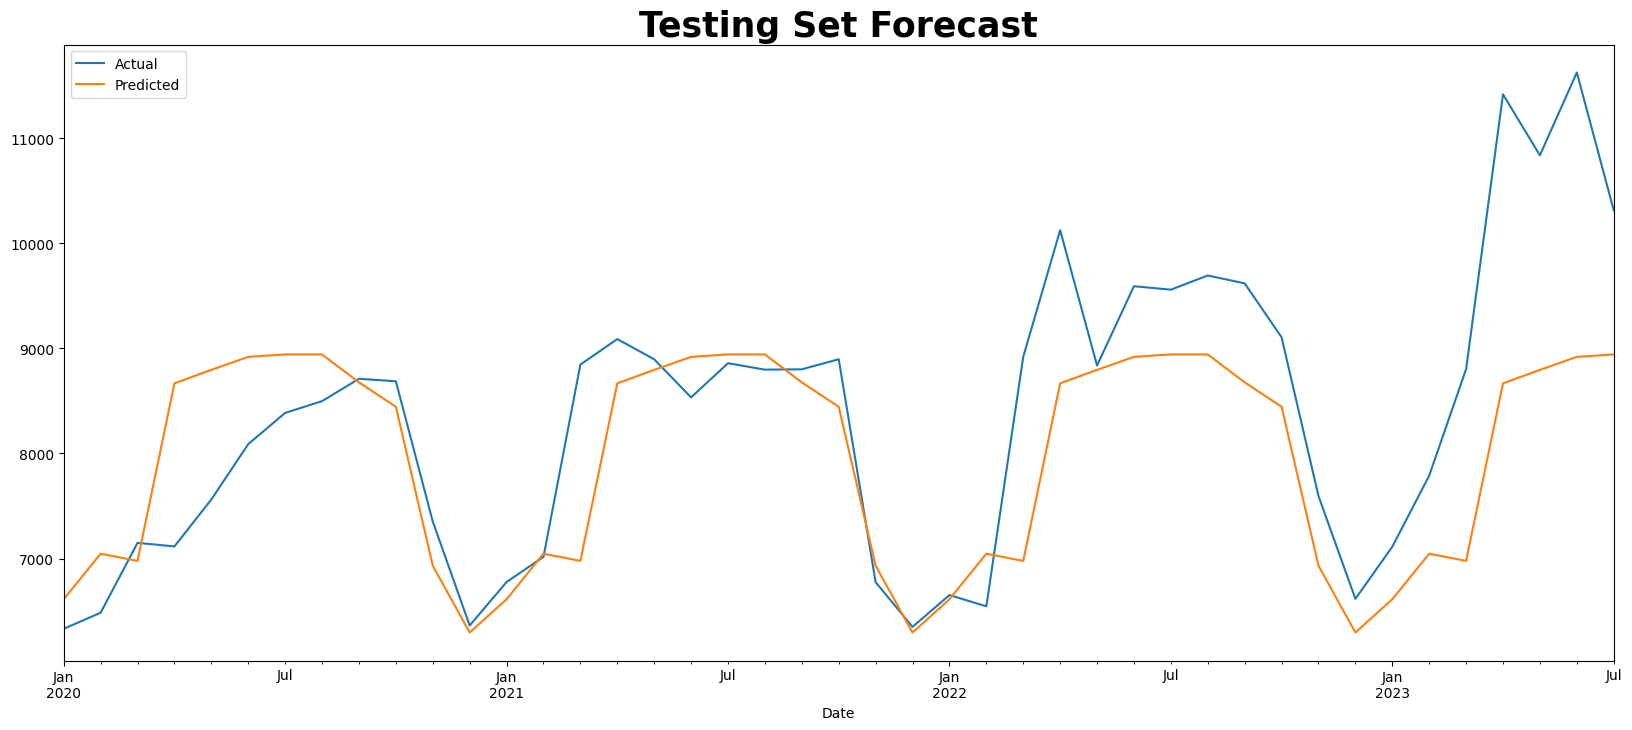

In [45]:
mae = round(mean_absolute_error(y_test, xgb_pred), 4)

df_plot = pd.DataFrame({'y_test':y_test, 'xgb_pred':xgb_pred})

plt.figure(figsize=(20,8))

df_plot['y_test'].plot(label='Actual')
df_plot['xgb_pred'].plot(label='Predicted')
#plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [46]:
print(mae)

719.3034


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Predict the value for next 7 months</b></h1>

In [47]:
future_months2 = future_months.iloc[-15:, :].copy()

future_months2['ds'] = pd.to_datetime(future_months2['ds'])
future_months2 = future_months2.set_index('ds')

#future_dates2['Hour'] = future_dates2.index.hour
#future_dates2['Dayofweek'] = future_dates2.index.dayofweek
#future_dates2['Dayofmonth'] = future_dates2.index.day
#future_dates2['Dayofyear'] = future_dates2.index.dayofyear
#future_dates2['weekofyear'] = future_dates2.index.weekofyear
future_months2['Month'] = future_months2.index.month
future_months2['Quarter'] = future_months2.index.quarter
future_months2['Year'] = future_months2.index.year

In [48]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [49]:
xgb_model2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model2.fit(X, y, eval_metric='mae')
xgb_pred2 = xgb_model2.predict(future_months2)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


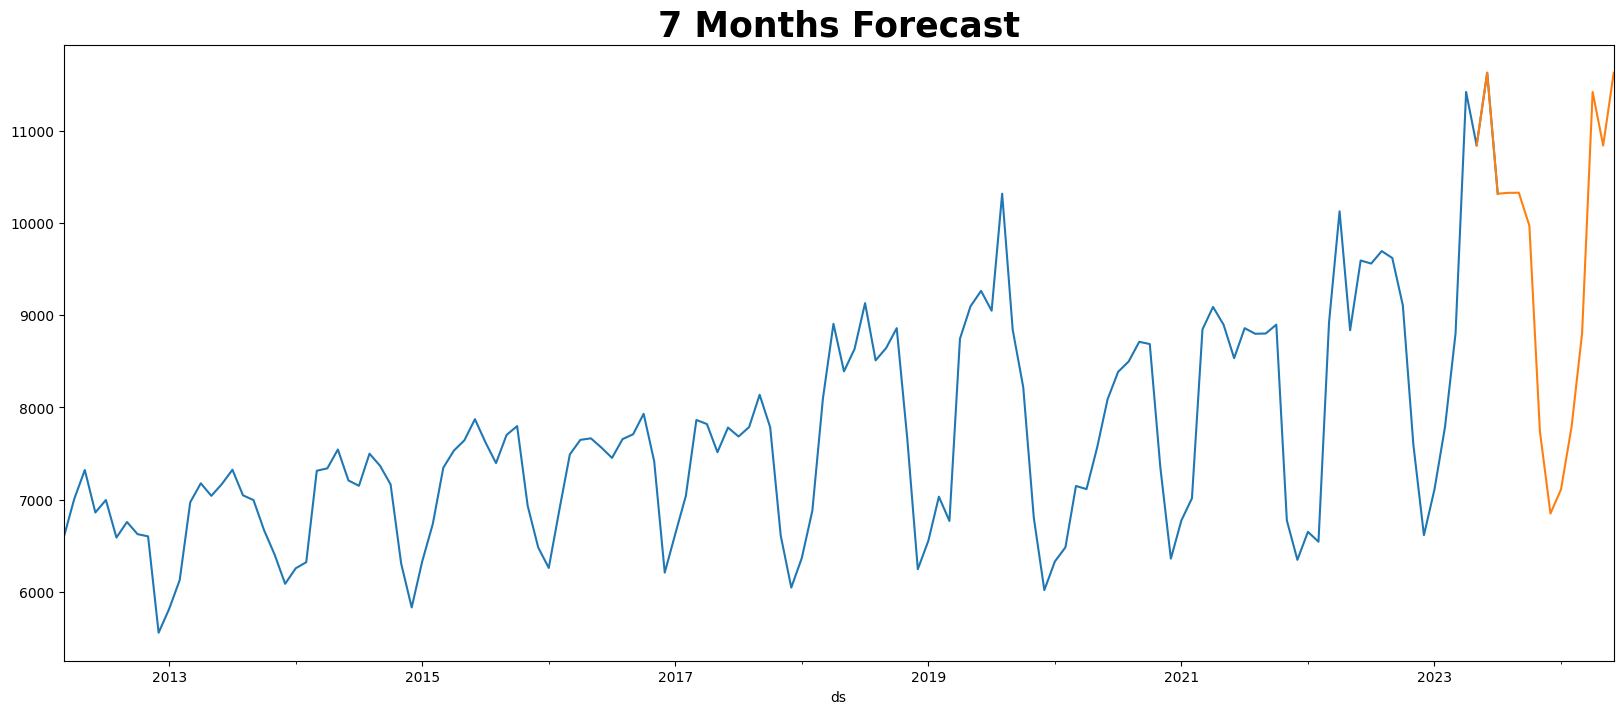

In [50]:
df_plot2 = pd.DataFrame({'Month':future_months2['Month'], 'xgb_pred2':xgb_pred2})

last_week = df_data['2012-03-01':'2025-08-1']

plt.figure(figsize=(20,8))

last_week['PeakDemand_MW'].plot()
df_plot2['xgb_pred2'].plot()
plt.title('7 Months Forecast', weight='bold', fontsize=25)
plt.show()

##<a id="7"></a>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>3. Deep Neaural Network</b></h1>

The Deep Learning framework we are using is Tensorflow

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Preparing features and labels</b></h1>

Before feeding the data into Neural Network, we have to do some modification to the data so they can be accepted by the model. We are going to use windowing technique which basically group the data into feature and label. The label will be the next value. You can take a look at the next few cells to give an idea what we are going to do

Official Documentation: [Here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Helpful Resource:

* https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0

In [51]:
# EXAMPLE

dataset = tf.expand_dims(df_train['PeakDemand_MW'].head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(6, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(6))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[6089.]
 [6301.]
 [6382.]
 [6478.]
 [6555.]]
y =  [5947.]

x =  [[6301.]
 [6382.]
 [6478.]
 [6555.]
 [5947.]]
y =  [5970.]

x =  [[6382.]
 [6478.]
 [6555.]
 [5947.]
 [5970.]]
y =  [5610.]

x =  [[6478.]
 [6555.]
 [5947.]
 [5970.]
 [5610.]]
y =  [6186.]

x =  [[6555.]
 [5947.]
 [5970.]
 [5610.]
 [6186.]]
y =  [6592.]



<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Build and train the model</b></h1>

In [52]:
def windowing(data, window_size, shuffle_buffer, batch_size):
    dataset = tf.expand_dims(data, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) # window size = 24 + 1 (test)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # (train, test)
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [53]:
train = windowing(df_train['PeakDemand_MW'], 6, 10, 6)
test = windowing(df_test['PeakDemand_MW'], 6, 10, 6)

In [54]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[6,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 16)             64        
                                                                 
 bidirectional (Bidirection  (None, 32)                4224      
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4833 (18.88 KB)
Trainable params: 4833 (18.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
dnn_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=1000)

Epoch 1/1000
17/17 [==============================] - 7s 57ms/step - loss: 6039.3228 - val_loss: 5248.8262
Epoch 2/1000
17/17 [==============================] - 0s 28ms/step - loss: 3659.1394 - val_loss: 4524.3462
Epoch 3/1000
17/17 [==============================] - 0s 21ms/step - loss: 2301.6399 - val_loss: 2392.7854
Epoch 4/1000
17/17 [==============================] - 0s 21ms/step - loss: 1090.9052 - val_loss: 1843.0645
Epoch 5/1000
17/17 [==============================] - 0s 21ms/step - loss: 962.6220 - val_loss: 2248.0208
Epoch 6/1000
17/17 [==============================] - 0s 22ms/step - loss: 1367.5359 - val_loss: 1574.0631
Epoch 7/1000
17/17 [==============================] - 0s 22ms/step - loss: 711.7711 - val_loss: 1272.0364
Epoch 8/1000
17/17 [==============================] - 0s 21ms/step - loss: 736.1009 - val_loss: 1493.1261
Epoch 9/1000
17/17 [==============================] - 0s 21ms/step - loss: 797.5343 - val_loss: 1305.1918
Epoch 10/1000
17/17 [====================

<Axes: >

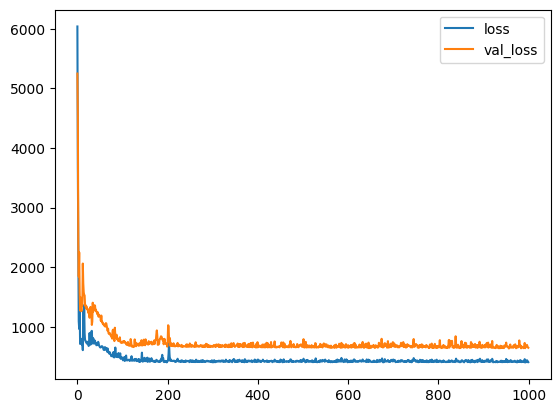

In [56]:
metric = pd.DataFrame(dnn_model.history.history)
metric.plot()

In [57]:
import numpy as np

window_size =6
forecast = []

train_length = len(df_train)
forecast_series = df_data[train_length - window_size:]

# Convert the forecast_series to a compatible NumPy array
forecast_series_np = np.array(forecast_series['PeakDemand_MW'])

# Use the model to predict data points per window size
for time in range(len(forecast_series_np) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series_np[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()


1/1 [==============================] - 0s 28ms/step


<ipython-input-58-04edea342f7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Pred'] = results


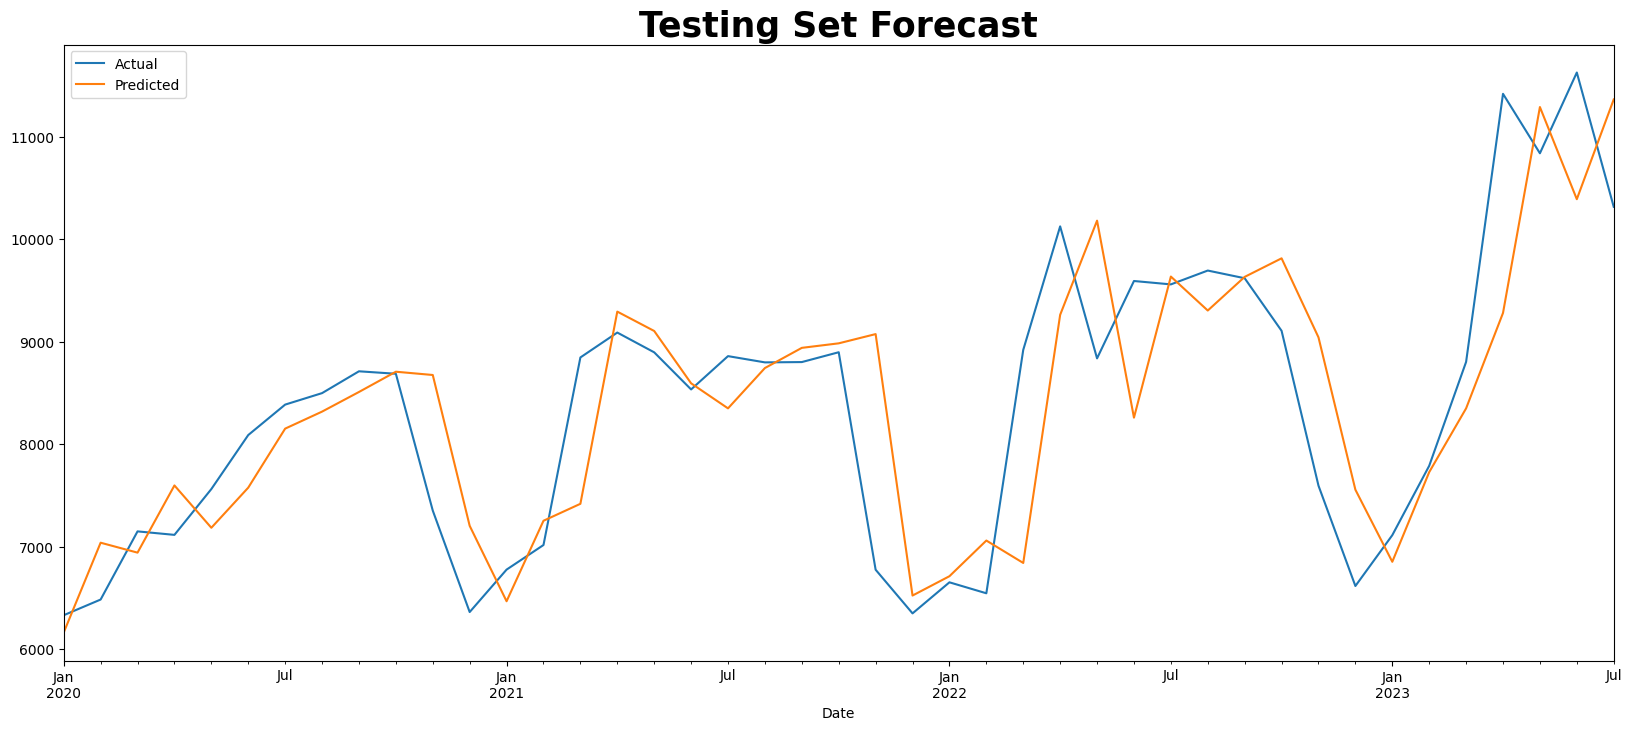

In [58]:

df_test['Pred'] = results

mae = round(mean_absolute_error(df_test['PeakDemand_MW'], df_test['Pred']), 3)

plt.figure(figsize=(20,8))

df_test['PeakDemand_MW'].plot(label='Actual')
df_test['Pred'].plot(label='Predicted')
#plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [59]:
print(mae)

609.989


In [60]:
window_size = 6

df_forecast = df_test[['Pred']][-6:]
last_date = df_forecast.index

for time in range(7): # 7 months ahead
    # Convert the dataframe slice to a compatible NumPy array
    forecast_data = np.array(df_forecast['Pred'][time:time + window_size])

    # Reshape and expand the dimensions to match the expected input shape of the model
    forecast_data = np.expand_dims(forecast_data, axis=-1)
    forecast_data = np.expand_dims(forecast_data, axis=0)

    # Use the model to predict the next data point
    pred = dnn_model.predict(forecast_data)[0][0]

    # Append the prediction to the dataframe
    df_forecast = df_forecast.append({'Pred': pred}, ignore_index=True)

date_index = pd.date_range('2023-01-01', periods=13, freq='M') # 3+7
df_forecast.set_index(date_index, inplace=True)

1/1 [==============================] - 0s 19ms/step


<ipython-input-60-05e0a17f7693>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast = df_forecast.append({'Pred': pred}, ignore_index=True)
<ipython-input-60-05e0a17f7693>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast = df_forecast.append({'Pred': pred}, ignore_index=True)
<ipython-input-60-05e0a17f7693>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast = df_forecast.append({'Pred': pred}, ignore_index=True)
<ipython-input-60-05e0a17f7693>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast = df_forecast.append({'Pred': pred}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-60-05e0a17f7693>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast = df_forecast.append({'Pred': pred}, ignore_index=True)
<ipython-input-60-05e0a17f7693>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast = df_forecast.append({'Pred': pred}, ignore_index=True)
<ipython-input-60-05e0a17f7693>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast = df_forecast.append({'Pred': pred}, ignore_index=True)


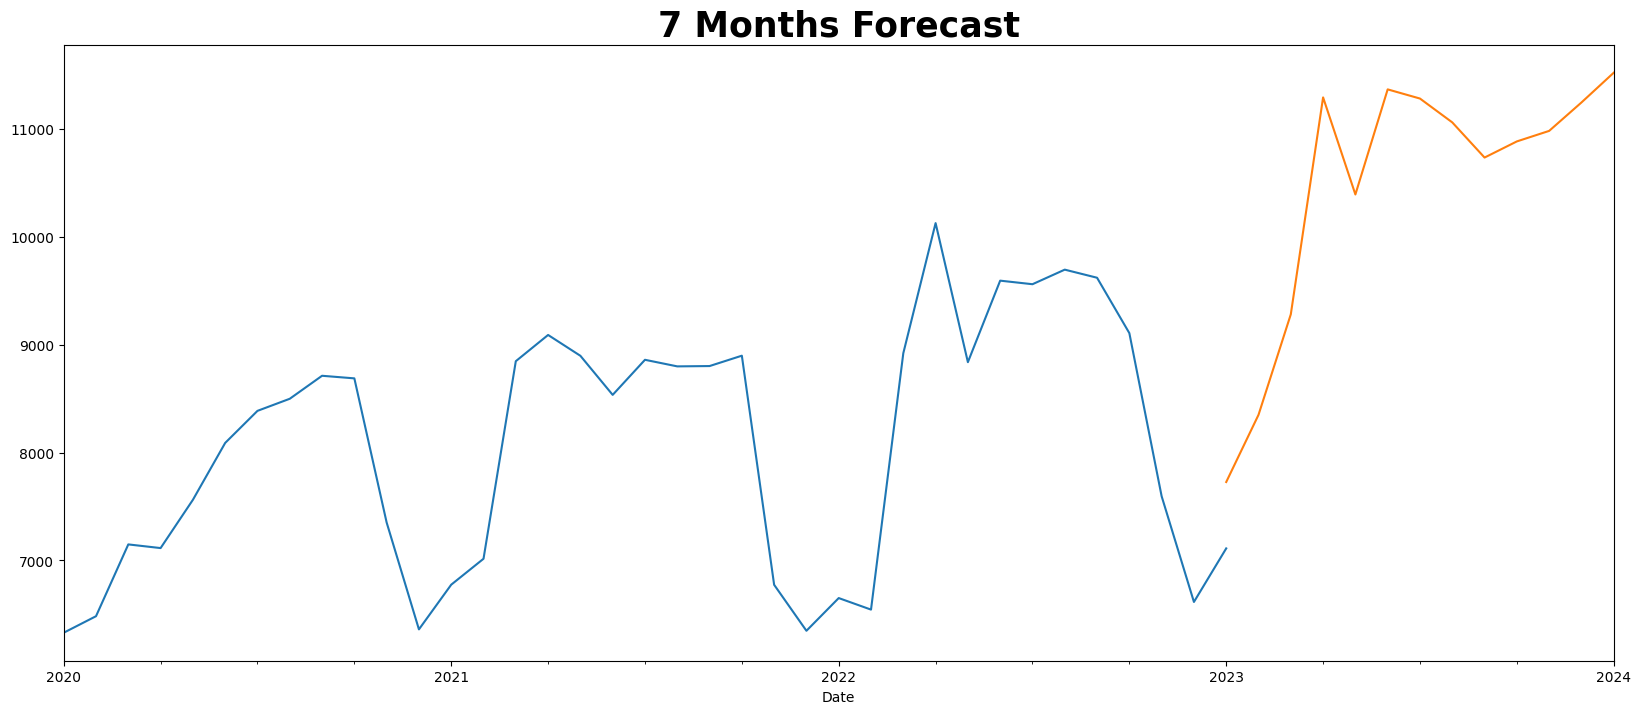

In [61]:
plt.figure(figsize=(20,8))

df_test['PeakDemand_MW'][-130:-6].plot()
df_forecast['Pred'].plot()
plt.title('7 Months Forecast', weight='bold', fontsize=25)
plt.show()

In [62]:
tf.keras.models.save_model(dnn_model,'my_dnn_model.hdf5')

<ipython-input-62-975494e76dce>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(dnn_model,'my_dnn_model.hdf5')
